In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x240e3b11888>,
 'tobs': 65.0,
 'date': '2010-01-01',
 'prcp': 0.08,
 'station': 'USC00519397',
 'id': 1}

In [10]:
# Find the most recent date in the data set.
session.query(Measurement.date).order_by(Measurement.date.desc()).first()


('2017-08-23',)

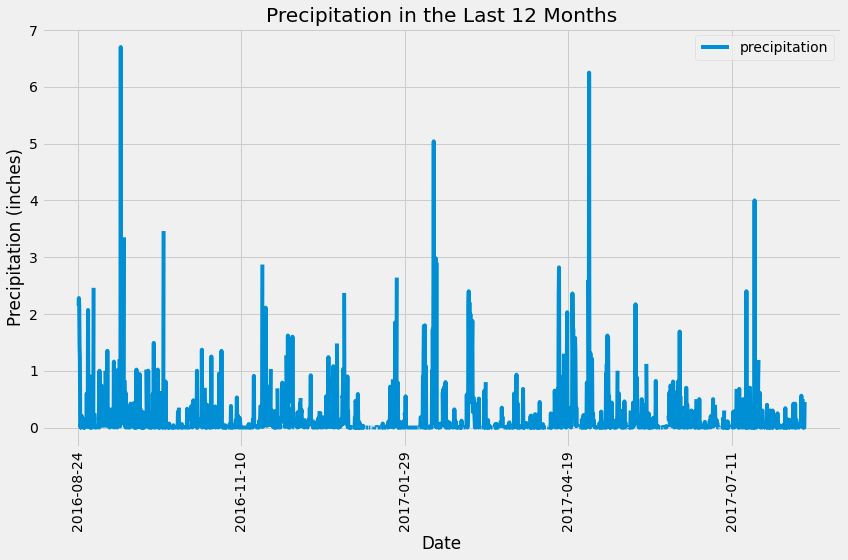

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Find the most recent date in the data set.
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]

# Calculate the date one year from the last date in the dataset.
year_ago_date = dt.datetime.strptime(latest_date, '%Y-%m-%d') - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores.
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= year_ago_date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column.
df = pd.DataFrame(results, columns=['date', 'precipitation'])
df.set_index('date', inplace=True)

# Sort the dataframe by date.
df = df.sort_index()

# Use Pandas Plotting with Matplotlib to plot the data.
df.plot(figsize=(12,8), rot=90)
plt.title("Precipitation in the Last 12 Months")
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")
plt.tight_layout()
plt.show()

In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data.
print(df.describe())


       precipitation
count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000


# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number of stations in the dataset.
total_stations = session.query(func.count(Station.station)).scalar()

print(f"There are a total of {total_stations} stations in the dataset.")


There are a total of 9 stations in the dataset.


In [14]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.

station_activity = session.query(Measurement.station, func.count(Measurement.station)).\
                    group_by(Measurement.station).\
                    order_by(func.count(Measurement.station).desc()).all()

# Print the results
for station, count in station_activity:
    print(f"{station}: {count}")


USC00519281: 2772
USC00519397: 2724
USC00513117: 2709
USC00519523: 2669
USC00516128: 2612
USC00514830: 2202
USC00511918: 1979
USC00517948: 1372
USC00518838: 511


In [15]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = station_activity[0][0]

temp_stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
             filter(Measurement.station == most_active_station).all()

# Print the results
print(f"For the most active station ({most_active_station}), the lowest temperature was {temp_stats[0][0]} F, the highest temperature was {temp_stats[0][1]} F, and the average temperature was {temp_stats[0][2]:.1f} F.")


For the most active station (USC00519281), the lowest temperature was 54.0 F, the highest temperature was 85.0 F, and the average temperature was 71.7 F.


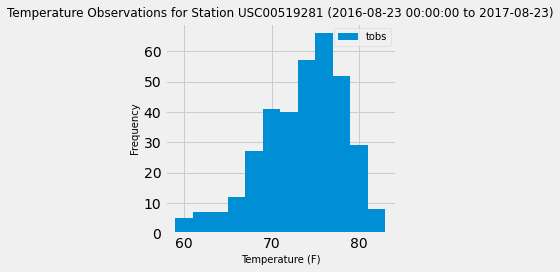

In [16]:
# Using the most active station id
# Calculate the date one year from the last date in data set.
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
one_year_ago = dt.datetime.strptime(last_date, "%Y-%m-%d") - dt.timedelta(days=365)

# Query the last 12 months of temperature observation data for the most active station
temp_data = session.query(Measurement.tobs).\
            filter(Measurement.station == most_active_station).\
            filter(Measurement.date >= one_year_ago).all()

# Convert the query results to a Pandas DataFrame
temp_df = pd.DataFrame(temp_data, columns=["Temperature (F)"])

# Plot the results as a histogram
plt.hist(temp_df["Temperature (F)"], bins=12, label="tobs")

# Set the chart title and axis labels
plt.title(f"Temperature Observations for Station {most_active_station} ({one_year_ago} to {last_date})", fontsize=12)
plt.xlabel("Temperature (F)", fontsize=10)
plt.ylabel("Frequency", fontsize=10)

# Set the legend and chart style
plt.legend(fontsize=10)
plt.tight_layout()
plt.style.use("fivethirtyeight")
plt.show()



# Close session

In [18]:
# Close Session
session.close()